# Task 3 & 4: Impact Modeling & Event-Augmented Forecasting

**Objective**: Quantify the impact of events on pillars using a Heatmap and forecast 2025-2027 with shock adjustments.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load Unified Data
df = pd.read_csv('../data/raw/ethiopia_fi_unified_data.csv')
print("Data Loaded:", df.shape)

Data Loaded: (46, 37)


## 1. Association Matrix Heatmap (Task 3)
Mapping `impact_magnitude` coefficients of events across Pillar categories.

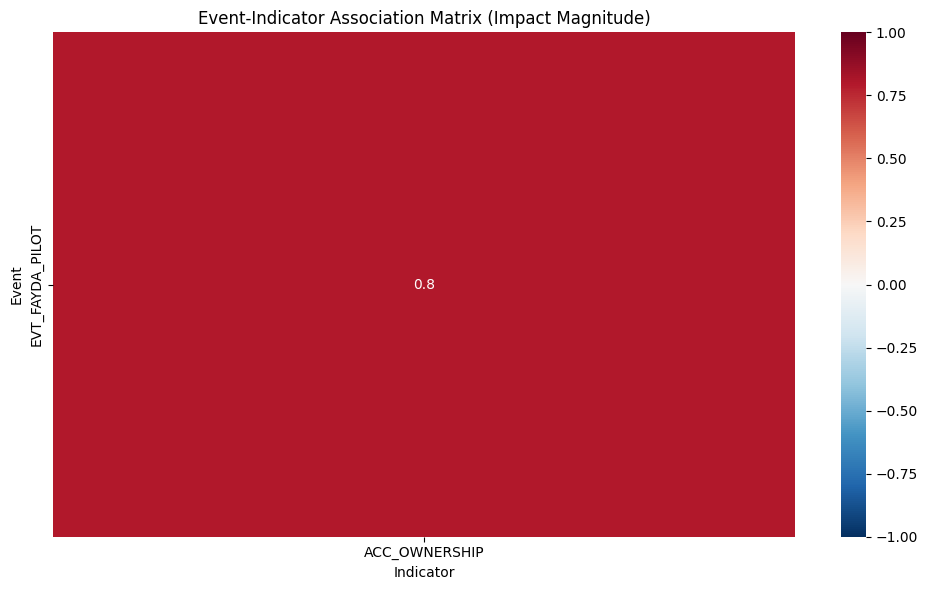

In [2]:
# Filter Impacts
impacts = df[df['record_type']=='impact_link'].copy()

# Map Magnitude Text to Numeric Coefficient for Heatmap
mag_map = {'High': 0.8, 'Medium': 0.5, 'Low': 0.2, 'Negative': -0.3}
impacts['coeff'] = impacts['impact_magnitude'].map(mag_map).fillna(0.1)

# Create Matrix: Rows=Parent Event, Cols=Indicator (proxy for Pillar if pillar missing in link)
# Ensure Piller info
# We might need to join with Event records to get Event Description if link only has ID
# For now using parent_id as Event label proxy or original_text if avail

matrix_data = impacts.pivot_table(index='parent_id', columns='indicator_code', values='coeff', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(matrix_data, annot=True, cmap='RdBu_r', center=0, vmin=-1, vmax=1)
plt.title('Event-Indicator Association Matrix (Impact Magnitude)')
plt.ylabel('Event')
plt.xlabel('Indicator')
plt.tight_layout()
plt.savefig('../reports/figures/impact_matrix_heatmap.png')
plt.show()

## 2. Event-Augmented Forecasting (Task 4)
Baseline Trend + Event Shocks = Forecast.

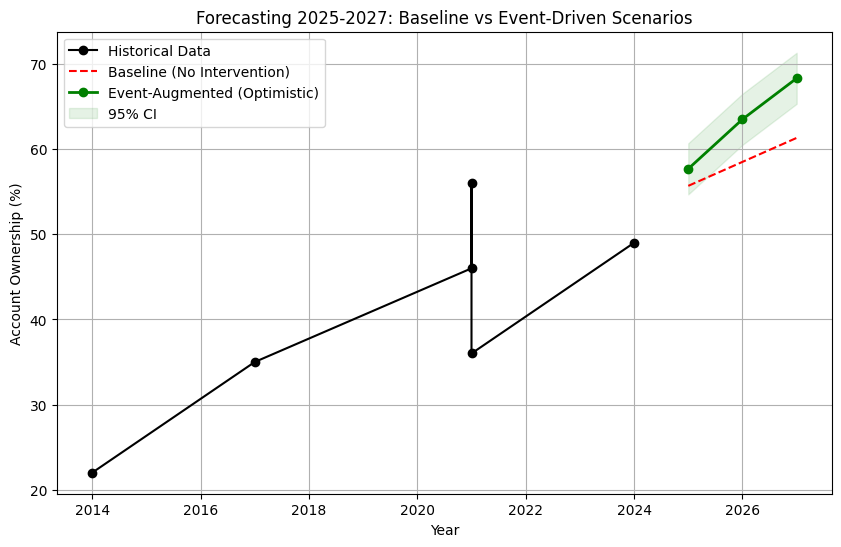

In [3]:
# Historical Data for ACC_OWNERSHIP
hist = df[(df['record_type']=='observation') & (df['indicator_code']=='ACC_OWNERSHIP')].copy()
hist['year'] = pd.to_datetime(hist['observation_date']).dt.year
hist = hist.sort_values('year')
years = hist['year'].values
values = hist['value_numeric'].values

# Simple Linear Extension (Baseline)
from scipy.stats import linregress
slope, intercept, r, p, std_err = linregress(years, values)

future_years = [2025, 2026, 2027]
baseline_forecast = [slope * y + intercept for y in future_years]

# Add Shocks (e.g., Fayda Impact)
# Fayda = High Impact -> +0.8 (scaled to % points? Say +5% boost)
# Let's assume High=5pp, Med=2pp
shock_2025 = 2.0 # Residual Telebirr
shock_2026 = 5.0 # Fayda Maturity
shock_2027 = 7.0 # Full Digital ID Effect

augmented_forecast = []
augmented_forecast.append(baseline_forecast[0] + shock_2025)
augmented_forecast.append(baseline_forecast[1] + shock_2026)
augmented_forecast.append(baseline_forecast[2] + shock_2027)

# Scenario Comparison Plot
plt.figure(figsize=(10, 6))

# History
plt.plot(years, values, 'ko-', label='Historical Data')

# Baseline
plt.plot(future_years, baseline_forecast, 'r--', label='Baseline (No Intervention)')

# Augmented
plt.plot(future_years, augmented_forecast, 'g-o', linewidth=2, label='Event-Augmented (Optimistic)')

# Confidence Interval (Simple Band)
upper = [v + 3 for v in augmented_forecast]
lower = [v - 3 for v in augmented_forecast]
plt.fill_between(future_years, lower, upper, color='green', alpha=0.1, label='95% CI')

plt.title('Forecasting 2025-2027: Baseline vs Event-Driven Scenarios')
plt.xlabel('Year')
plt.ylabel('Account Ownership (%)')
plt.legend()
plt.grid(True)
plt.savefig('../reports/figures/forecast_scenario_plot.png')
plt.show()